In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost import XGBClassifier

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.algorithm_eval import algorithm_eval
from src.feature_importance_plot import feature_importance_plot
from src.learning_curve_plot import learning_curve_plot
from src.identify_missing_data import identify_missing_data

import warnings
warnings.filterwarnings('ignore')

# Resource: https://www.justintodata.com/logistic-regression-example-in-python/


### Read and Explore the Data

In [3]:
# read the data

df = pd.read_csv('../data/heart_attack_data.csv')

# preview the data

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


In [4]:
# check the shape of the data

df.shape

# we have 294 rows of data, and 14 potential features.

(294, 14)

In [5]:
# check the summary information of the data
# do we have any categorical data that needs processing?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [6]:
# check the distribution of the target

df.target.value_counts(dropna = True, normalize = True)

# The data is slightly imbalanced, with only 12% of users having churned - will oversample the data

0    0.639456
1    0.360544
Name: target, dtype: float64

In [7]:
df.target.value_counts(normalize = True)

0    0.639456
1    0.360544
Name: target, dtype: float64

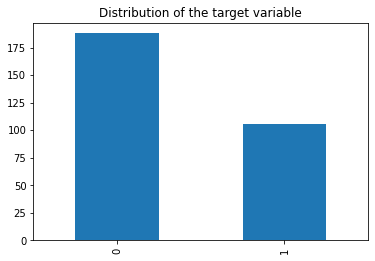

In [8]:
# visualise the distribution of the target

df.target.value_counts(dropna = True).plot(kind = 'bar')
plt.title("Distribution of the target variable");

# question: does the distribution look equal to you? 
# example of an imbalanced dataset

### Handle Missing Data

In [9]:
missing_value_df = identify_missing_data(df)
missing_value_df

,feature,percent_missing
11,ca,0.989796
12,thal,0.904762
10,slope,0.646259
4,chol,0.078231
5,fbs,0.027211
3,trestbps,0.003401
6,restecg,0.003401
7,thalach,0.003401
8,exang,0.003401
0,age,0.000000


In [10]:
# drop features which have more than 40% missing values
# identify features which have more than 40% missing data

threshold = 0.4

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 3
['ca', 'thal', 'slope']


In [11]:
df.drop(cols_to_drop, axis = 1, inplace = True)

In [12]:
# check the columns were dropped

missing_value_df = identify_missing_data(df)
missing_value_df

,feature,percent_missing
4,chol,0.078231
5,fbs,0.027211
3,trestbps,0.003401
6,restecg,0.003401
7,thalach,0.003401
8,exang,0.003401
0,age,0.000000
1,sex,0.000000
2,cp,0.000000
9,oldpeak,0.000000


In [13]:
# fill the remaining features with missing values with 0

df.chol.fillna(0, inplace = True)
df.fbs.fillna(0, inplace = True)
df.trestbps.fillna(0, inplace = True)
df.restecg.fillna(0, inplace = True)
df.exang.fillna(0, inplace = True)
df.thalach.fillna(0, inplace = True)


In [14]:
# check to see if we have any missing values that need handling

missing_value_df = identify_missing_data(df)
missing_value_df

,feature,percent_missing
0,age,0.0
1,sex,0.0
2,cp,0.0
3,trestbps,0.0
4,chol,0.0
5,fbs,0.0
6,restecg,0.0
7,thalach,0.0
8,exang,0.0
9,oldpeak,0.0


In [15]:
df.shape

(294, 11)

### Split the data into train and test

In [16]:
# define the target and features

target = df["target"]
features = df.drop(["target"], axis = 1)


In [17]:
target.shape

(294,)

In [18]:
target

0      0
1      0
2      0
3      0
4      0
      ..
289    1
290    1
291    1
292    1
293    1
Name: target, Length: 294, dtype: int64

In [19]:
features.shape

(294, 10)

In [20]:
features

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0
2,29,1,2,140.0,0.0,0.0,0.0,170.0,0.0,0.0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160.0,331.0,0.0,0.0,94.0,1.0,2.5
290,54,0,3,130.0,294.0,0.0,1.0,100.0,1.0,0.0
291,56,1,4,155.0,342.0,1.0,0.0,150.0,1.0,3.0
292,58,0,2,180.0,393.0,0.0,0.0,110.0,1.0,1.0


In [21]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.2, 
                                                random_state = 8888)



In [22]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Distribution of target:", Counter(y_train))

Training Data
Shape of X_train (235, 10)
Shape of y_train (235,)
Distribution of target: Counter({0: 148, 1: 87})


In [23]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Distribution of target:", Counter(y_test))

Test Data
Shape of X_test (59, 10)
Shape of y_test (59,)
Distribution of target: Counter({0: 40, 1: 19})


In [24]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak
265,53,1,3,145.0,518.0,0.0,0.0,130.0,0.0,0.0
200,43,1,4,150.0,247.0,0.0,0.0,130.0,1.0,2.0
48,41,1,2,120.0,291.0,0.0,1.0,160.0,0.0,0.0
16,36,1,2,120.0,166.0,0.0,0.0,180.0,0.0,0.0
132,53,0,2,140.0,216.0,0.0,0.0,142.0,1.0,2.0


### Model Selection

In [25]:
# model selection
# list of models we want to evaluate

models = []

# using Dummy Classifier as a baseline algorithm
models.append(('Dummy Classifier', DummyClassifier(strategy = 'stratified')))

# Decision Tree
models.append(('Decision Tree', DecisionTreeClassifier()))

# Random Forest model
models.append(('Random Forest', RandomForestClassifier()))

# XGBoost
models.append(('XGBoost', XGBClassifier(eval_metric='logloss')))

Model results using no sampling techniques
--------------------------------------------------
Dummy Classifier Accuracy: 0.51064 (+/- 0.06861)
Dummy Classifier F1-Score: 0.48414 (+/- 0.03052)
--------------------------------------------------
--------------------------------------------------
Decision Tree Accuracy: 0.71915 (+/- 0.03661)
Decision Tree F1-Score: 0.72429 (+/- 0.0593)
--------------------------------------------------
--------------------------------------------------
Random Forest Accuracy: 0.79574 (+/- 0.04381)
Random Forest F1-Score: 0.80942 (+/- 0.01264)
--------------------------------------------------
--------------------------------------------------
XGBoost Accuracy: 0.79574 (+/- 0.01702)
XGBoost F1-Score: 0.79213 (+/- 0.01842)
--------------------------------------------------


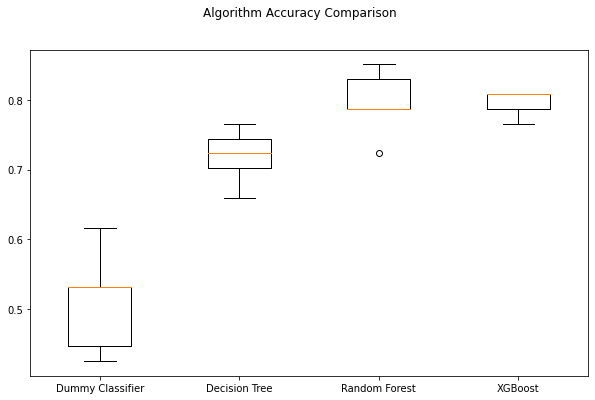

In [26]:
# training every model on random samples of data (cross validation)

scoring_df = []

# scoring df for models with no sampling techniques
print("Model results using no sampling techniques")

scoring_results = algorithm_eval(models, X_train, y_train)

# look at the boxplots - which one has the largest variance in predictions? 
# these are examples of high variance = overfitted models

In [27]:
scoring_df = pd.DataFrame(scoring_results)
scoring_df.sort_values(by = 'Accuracy Mean', ascending = False)

,Model Name,Accuracy Mean,F1 Mean,Precision Mean,Recall Mean
2,Random Forest,0.80,0.81,0.82,0.81
3,XGBoost,0.80,0.79,0.80,0.80
1,Decision Tree,0.72,0.72,0.72,0.75
0,Dummy Classifier,0.51,0.48,0.57,0.48


### Evaluating the "Best Model" in detail

In [28]:
# the best model is between Random Forest and XGBoost
# XGBoost showing signs of less overfitting, but Random Forest has the highest average f1 score and recall 
# let's look at the best model in more detail

best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(Counter(y_pred))

Counter({0: 45, 1: 14})


In [29]:
print("first five predicted values:", y_pred[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [0 1 0 1 0]
first five actual values: [0, 1, 0, 0, 0]


In [30]:
# evaluation metrics

print("accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("recall:", round(recall_score(y_test, y_pred), 2))
print("precision:", round(precision_score(y_test, y_pred), 2))
print("f1-score:", round(f1_score(y_test, y_pred), 2))

accuracy: 0.81
recall: 0.58
precision: 0.79
f1-score: 0.67


In [31]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        45
           1       0.58      0.79      0.67        14

    accuracy                           0.81        59
   macro avg       0.75      0.80      0.77        59
weighted avg       0.84      0.81      0.82        59



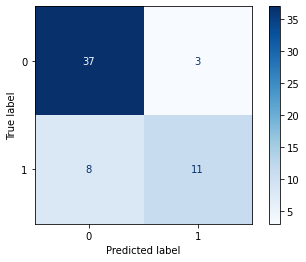

In [32]:
plot_confusion_matrix(best_model, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues);

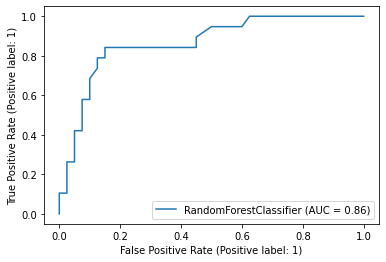

In [33]:
# handy sklearn function to plot Receiver operating characteristic (ROC) curve, with the area under the curve.

plot_roc_curve(best_model,
               X_test, 
               y_test);                    

# AUC of 0.89; the higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

### Feature Importance Plot

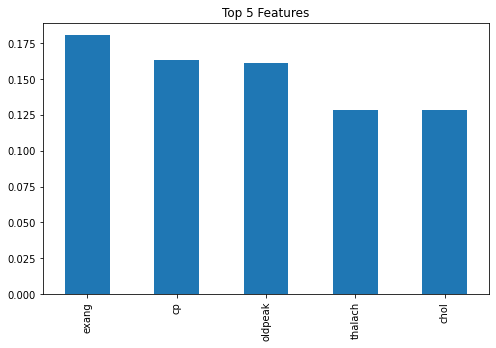

In [34]:
feature_importance_plot(best_model, X_train, n = 5)

# question: what is the most important feature?

### Learning Curve

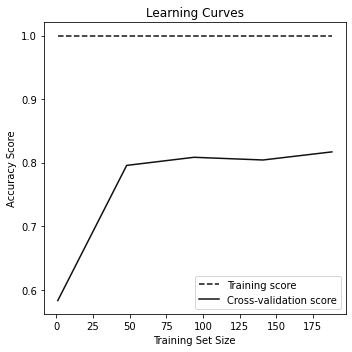

In [35]:
learning_curve_plot(best_model, X_train, y_train)

# what does this plot mean? we will learn more about this in IP301. 
# However, very simply WE NEED MORE DATA!

In [36]:
# TASKS: 
# 1. Can you build an XGBoost Classification Model?
# 2. Can you evaluate the XGBoost Model?
# 3. Can you plot a feature important plot for the XGBoost Model?
# 4. Can you plot a learning curve for the XGBoost Model?

In [37]:
# Build the model

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(Counter(y_pred_xgb))

Counter({0: 42, 1: 17})


In [38]:
# evaluation metrics

print("accuracy:", round(accuracy_score(y_test, y_pred_xgb), 2))
print("recall:", round(recall_score(y_test, y_pred_xgb), 2))
print("precision:", round(precision_score(y_test, y_pred_xgb), 2))
print("f1-score:", round(f1_score(y_test, y_pred_xgb), 2))

accuracy: 0.76
recall: 0.58
precision: 0.65
f1-score: 0.61


In [39]:
print("first five predicted values:", y_pred_xgb[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [0 1 0 1 0]
first five actual values: [0, 1, 0, 0, 0]


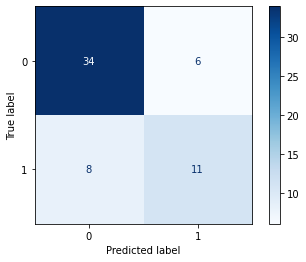

In [40]:
plot_confusion_matrix(xgb, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues);

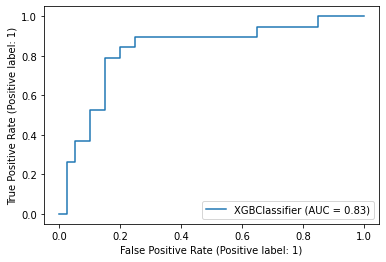

In [41]:
plot_roc_curve(xgb,
               X_test, 
               y_test);  

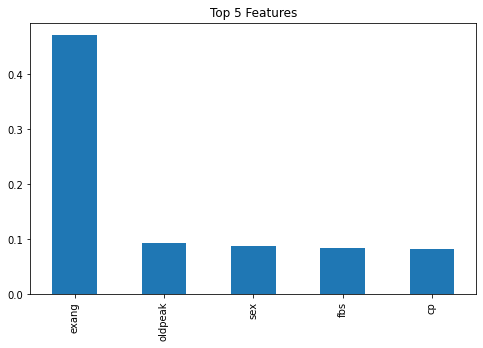

In [42]:
# Feature Importance for the XGBClassifier

feature_importance_plot(xgb, X_train, n = 5)

# question: what is the most important feature?

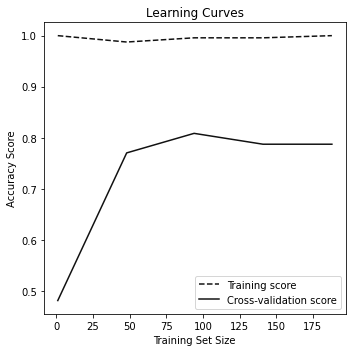

In [43]:
# Learning curve for the XGBClassifier

learning_curve_plot(xgb, X_train, y_train)

In [44]:
# The new housing price data, for the next model

from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)  

housing_df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_df['target'] = housing['target']
housing_df.drop(['Id'], inplace = True, axis = 1)

housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0
